<a href="https://colab.research.google.com/github/Gokul07745/python/blob/main/Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

Importing Necessary Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, f1_score,recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import roc_curve, auc


Splitting Datasets

In [ ]:
dataframe = pd.read_csv('/content/ecg.csv', header=None)
raw_data = dataframe.values

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)




In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# Convert labels to boolean
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Separate the normal and anomalous data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plotting Normal and anomalous ECG

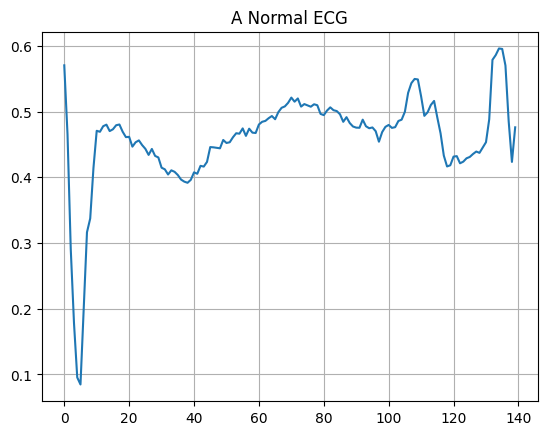

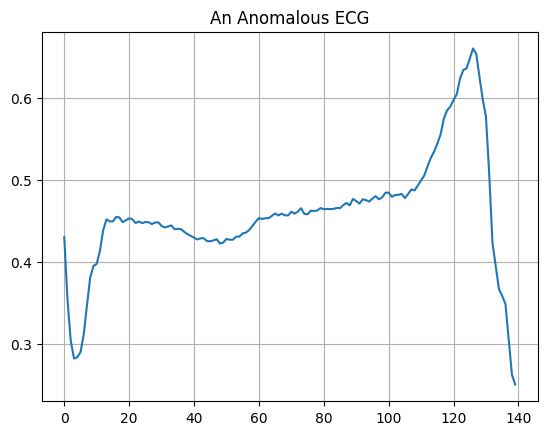

In [ ]:
# Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

# Plot an anomalous ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Model

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon



In [ ]:
class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu"),
            layers.Dense(4 + 4)  # Mean and log variance for 2 latent variables
        ])
        self.sampling = Sampling()
        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        z_mean, z_log_var = x[:, :4], x[:, 4:]
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed

Reconstruction Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

def reconstruction_loss(inputs, outputs):
    mse = MeanSquaredError()
    loss = mse(inputs, outputs)
    return tf.reduce_mean(loss)

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_log_var):

    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    return  reconstruction_loss(inputs,outputs) + kl_loss


Model Training

In [ ]:
vae = VAE()
vae.compile(optimizer='adam', loss=lambda inputs, outputs: vae_loss(inputs, outputs, vae.encoder(inputs)[:, :4], vae.encoder(inputs)[:, 4:]))

# Train the VAE
history = vae.fit(normal_train_data, normal_train_data,
                  epochs=20,
                  batch_size=512,
                  validation_data=(test_data, test_data),
                  shuffle=True)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1020 - val_loss: 0.0127
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - val_loss: 0.0094
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_loss: 0.0045
E

Training Loss and Validation Loss

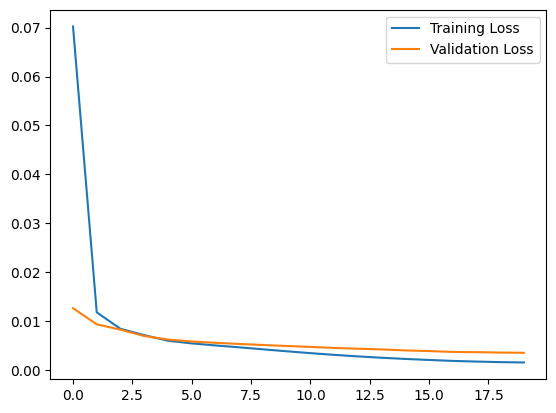

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


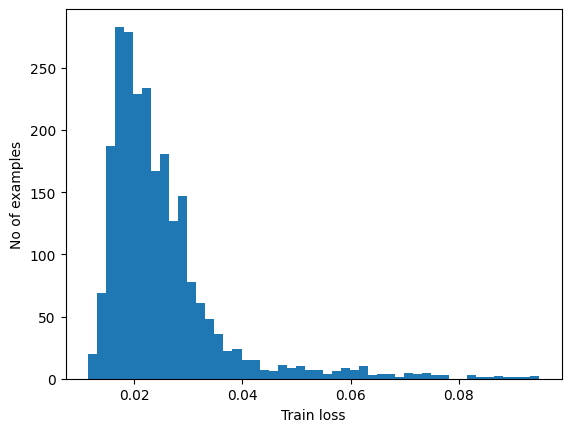

In [ ]:
reconstructions = vae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Setting Threshold Value

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


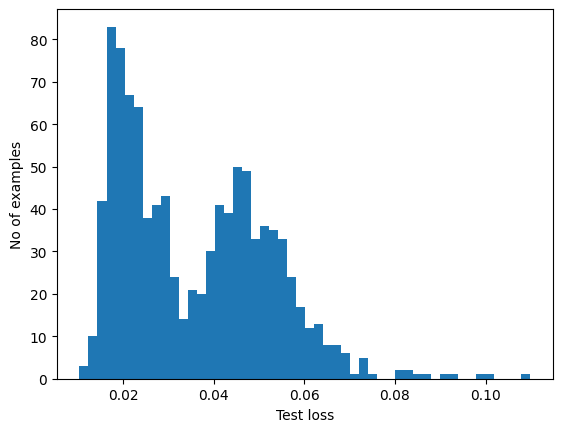

In [ ]:
reconstructions = vae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.036088727


Testing on Normal Data

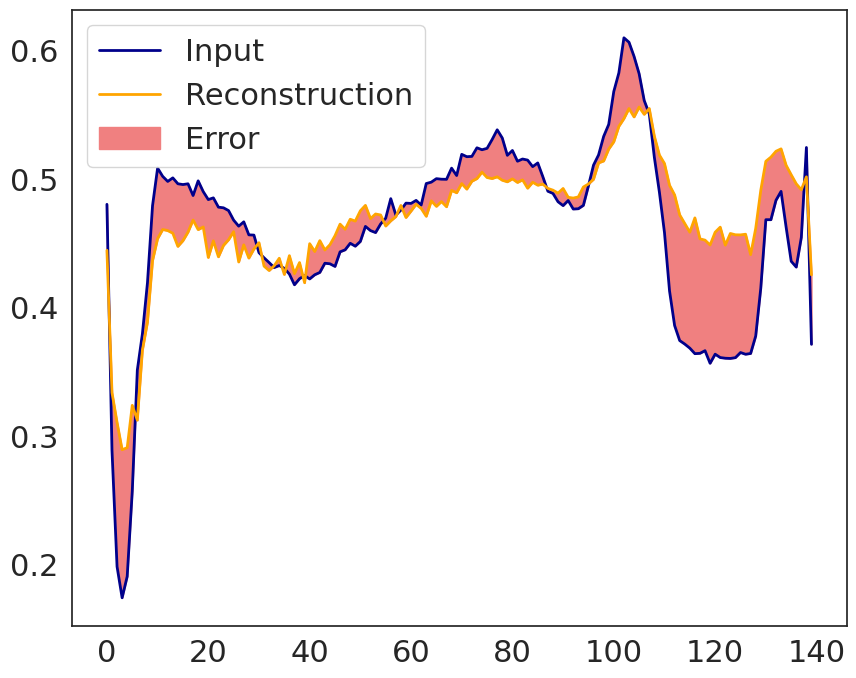

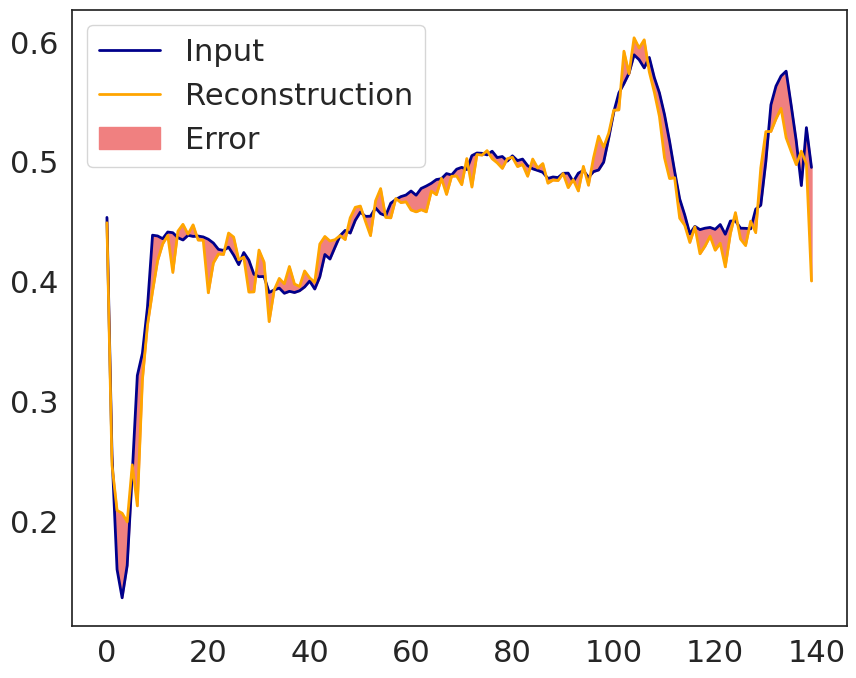

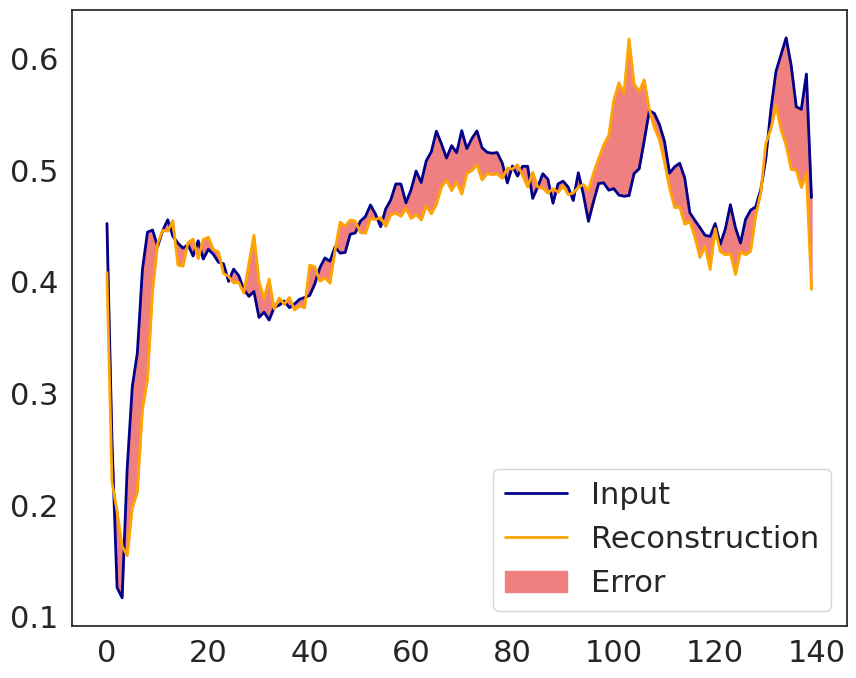

In [ ]:
# Encode the test data to get the mean and log variance
encoded_mean_logvar = vae.encoder(normal_test_data).numpy()

# Split the encoded output into mean and log variance
z_mean, z_log_var = encoded_mean_logvar[:, :4], encoded_mean_logvar[:, 4:]

# Sample from the latent space using the Sampling layer
epsilon = np.random.normal(size=z_mean.shape)
encoded_imgs = z_mean + np.exp(0.5 * z_log_var) * epsilon

# Decode the sampled latent vector
decoded_imgs = vae.decoder(encoded_imgs).numpy()

# Plot the results
for i in range(0, 3):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'darkblue', linewidth=2)
    plt.plot(decoded_imgs[i], 'orange', linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()


Testing on Anomalous Data

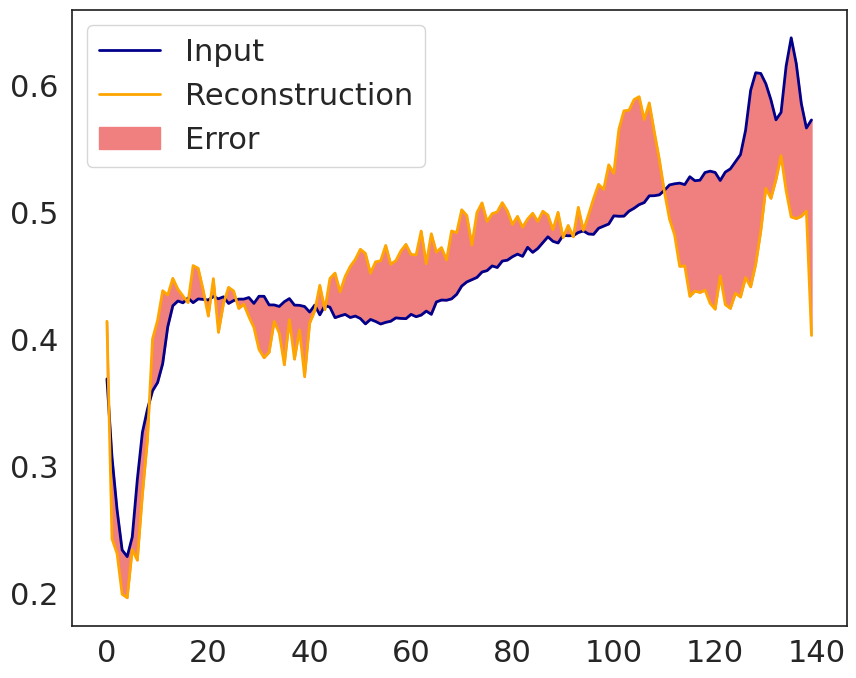

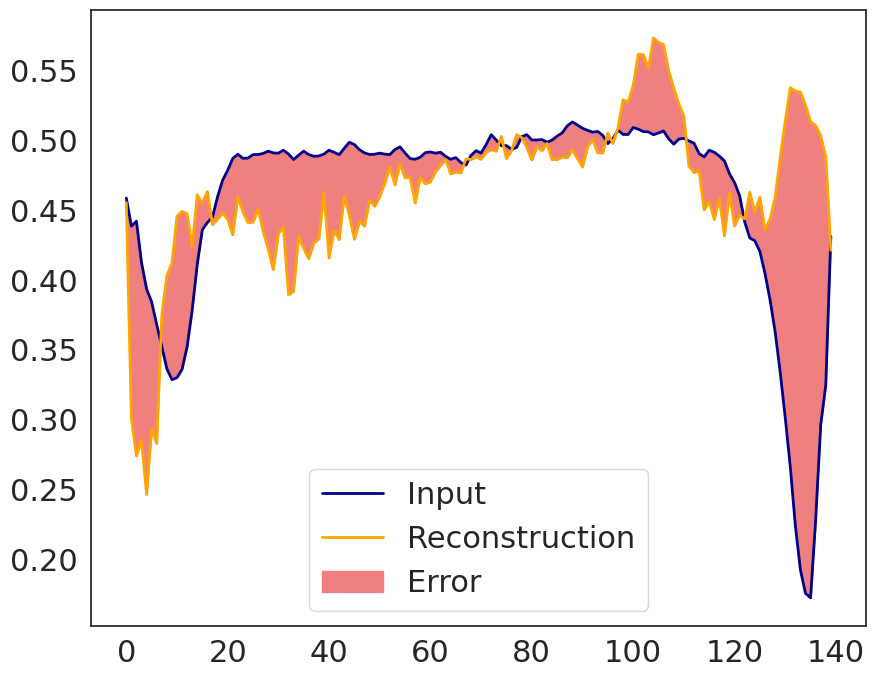

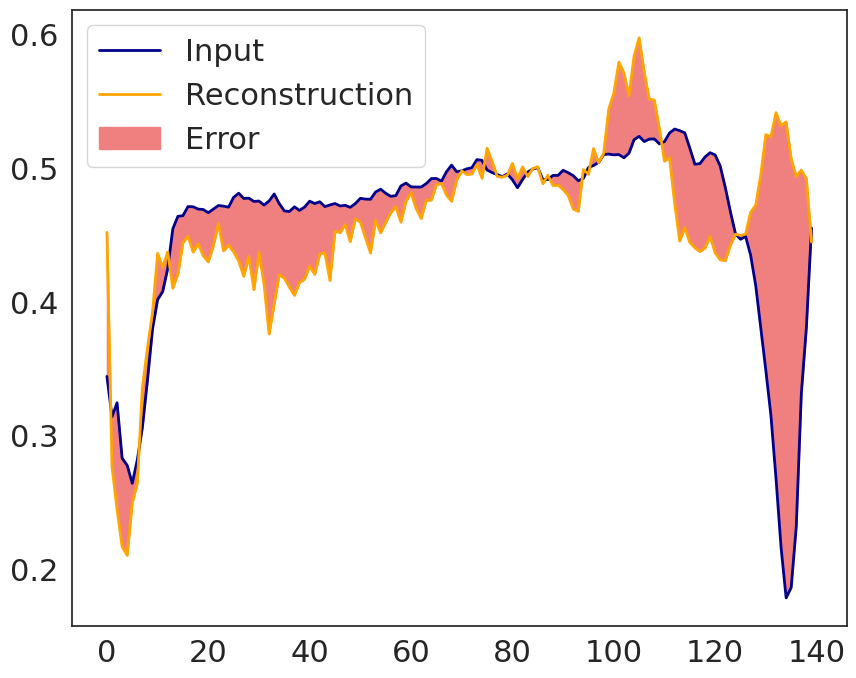

In [ ]:
encoded_mean_logvar = vae.encoder(anomalous_test_data).numpy()

# Split the encoded output into mean and log variance
z_mean, z_log_var = encoded_mean_logvar[:, :4], encoded_mean_logvar[:, 4:]

# Sample from the latent space using the mean and log variance
epsilon = np.random.normal(size=z_mean.shape)
encoded_imgs = z_mean + np.exp(0.5 * z_log_var) * epsilon

# Decode the sampled latent vector
decoded_imgs = vae.decoder(encoded_imgs).numpy()

# Plot the results for anomalous test data
for i in range(0, 3):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'darkblue', linewidth=2)
    plt.plot(decoded_imgs[i], 'orange', linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    print("Accuracy = {}".format(accuracy))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("F1-Score = {}".format(f1))
    print("Confusion Matrix:\n", conf_matrix)
    plot_confusion_matrix(conf_matrix)

In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Accuracy = 0.936
Precision = 0.9787644787644788
Recall = 0.9053571428571429
F1-Score = 0.9406307977736549
Confusion Matrix:
 [[429  11]
 [ 53 507]]


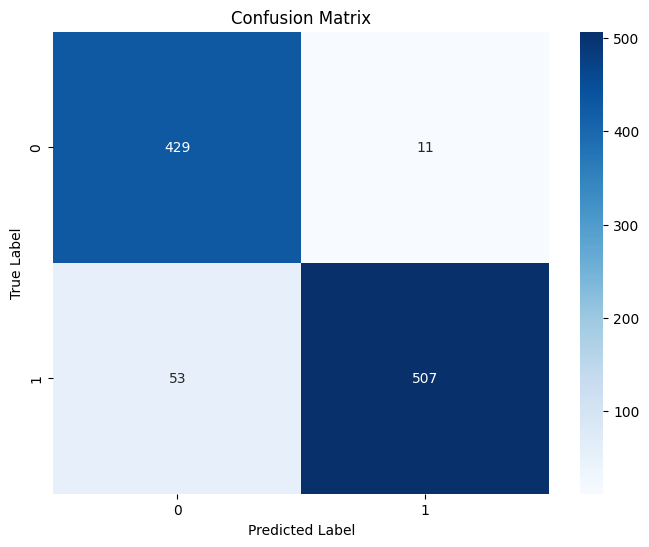

In [ ]:
preds = predict(vae, test_data, threshold)
print_stats(preds, test_labels)

In [ ]:
# Count the number of normal and anomalous data points
normal_train_count = np.sum(train_labels)
anomalous_train_count = len(train_labels) - normal_train_count

normal_test_count = np.sum(test_labels)
anomalous_test_count = len(test_labels) - normal_test_count

# Display the counts
print(f"Training Data:\n Normal: {normal_train_count}, Anomalous: {anomalous_train_count}")
print(f"Testing Data:\n Normal: {normal_test_count}, Anomalous: {anomalous_test_count}")


Training Data:
 Normal: 2359, Anomalous: 1639
Testing Data:
 Normal: 560, Anomalous: 440
